# EMO task

In [1]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

## Dependencies

In [2]:
!pip install transformers -q
!pip install accelerate -U -q
!pip install datasets -q
!pip install torch-summary -q
!pip install graphviz -q
!pip install torchview -q
!pip install bertviz -q

repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "main"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.5.0 requires botocore<1.29.77,>=1.29.76, but you have botocore 1.29.165 which is incompatible.


In [3]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-07-07 12:33:11--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19819 (19K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  19.35K  --.-KB/s    in 0s      

2023-07-07 12:33:12 (64.6 MB/s) - ‘utils.py’ saved [19819/19819]

--2023-07-07 12:33:13--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675 (10K) [text/pl

In [4]:
import json
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
from transformers import BertPreTrainedModel, BertModel
from transformers import RobertaModel,RobertaPreTrainedModel, BertForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
import importlib
import sys
from torch.utils.data import Dataset
from utils import *
importlib.reload(sys.modules['utils'])

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<module 'utils' from '/kaggle/working/utils.py'>

In [5]:
# set CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")

======= CUDA Available =======


## Dataset

Dataset paths

In [6]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_internal_train_preproc.tsv"
VAL_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_internal_val_preproc.tsv"
DEV_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_dev_preproc.tsv"

Read dataframes

In [7]:
train_df = pd.read_csv(TRAIN_DATA, sep='\t')
val_df = pd.read_csv(VAL_DATA, sep='\t')
dev_df = pd.read_csv(DEV_DATA, sep='\t')

Optional subsample

In [8]:
"""train_df = train_df[:20]
val_df = val_df[:10]
dev_df = dev_df[:10]"""

'train_df = train_df[:20]\nval_df = val_df[:10]\ndev_df = dev_df[:10]'

Encode targets

In [9]:
label_encoder = EmotionsLabelEncoder()
label_encoder.fit(train_df.emotion)

In [10]:
train_df

,conversation_id,article_id,essay,empathy,distress,speaker_id,gender,education,race,age,...,emotion,anger_count,disgust_count,fear_count,joy_count,sadness_count,surprise_count,hope_count,empathy_count,distress_count
0,193,313,It's so sad the turning event of Immigrants st...,6.333333,6.125,36,1,7,1,46,...,Hope/Sadness,6.896552,3.448276,10.344828,5.172414,15.517241,3.448276,0,8.220577,7.137115
1,340,223,I feel bad for the mother and her two daughter...,6.500000,2.875,30,1,6,3,37,...,Hope/Sadness,9.230769,7.692308,18.461538,15.384615,24.615385,12.307692,0,6.851257,6.467713
2,392,270,I feel so bad for the victims and the victims ...,6.000000,6.000,53,2,3,1,27,...,Hope/Sadness,8.943089,8.130081,10.569106,9.756098,9.756098,8.130081,0,3.762797,3.606506
3,304,347,"One of the biggest fears of a parent, is that ...",6.666667,6.375,30,1,6,3,37,...,Hope/Sadness,2.597403,1.298701,3.896104,19.480519,10.389610,6.493506,0,6.110432,5.607771
4,263,34,I feel sorry for the people living in that reg...,6.666667,6.625,30,1,6,3,37,...,Hope/Sadness,4.411765,4.411765,10.294118,14.705882,7.352941,10.294118,0,6.668359,6.151027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,266,47,Reading about the situation in Syria is always...,4.000000,3.125,25,1,4,1,29,...,Sadness/Surprise,3.125000,0.000000,7.812500,3.125000,3.125000,0.000000,0,7.022593,6.635832
613,319,39,I just read about an unfortunate wolf that had...,5.833333,4.750,25,1,4,1,29,...,Disgust/Surprise,10.169492,8.474576,8.474576,1.694915,11.864407,5.084746,0,7.559620,7.106100
614,419,301,I had to read this article over twice because ...,6.166667,6.000,19,1,6,2,32,...,Disgust/Surprise,4.285714,2.857143,2.857143,7.142857,5.714286,5.714286,0,6.532548,6.238817
615,479,53,I just read an article about the amount of foo...,1.000000,2.625,25,1,4,1,29,...,Disgust/Surprise,2.898551,2.898551,1.449275,8.695652,4.347826,0.000000,0,5.986728,5.726251


In [11]:
y_train = label_encoder.encode(train_df.emotion)
y_val = label_encoder.encode(val_df.emotion)
y_dev = label_encoder.encode(dev_df.emotion)

In [12]:
y_train.shape

(617, 8)

In [13]:
!pip install NRCLex -q #TODO: mettere su
!pip install textblob -q
!python -m textblob.download_corpora -q

[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /usr/share/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [14]:
class EMODataset(Dataset):

    def __init__(
        self,
        tokenizer,
        essay,
        targets,
        max_len=None
        ):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.essay = essay
        self.targets = targets

    def __len__(self):
        return len(self.essay)

    def __getitem__(self, index):
        essay = str(self.essay[index])
        inputs = self.tokenizer.encode_plus(
            text=essay,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
            return_token_type_ids=True
        )

        item = {
          'input_ids': inputs['input_ids'].flatten(),
          'attention_mask': inputs['attention_mask'].flatten(),
          'token_type_ids': inputs["token_type_ids"].flatten()
        }
        emos = ['fear','anger','anticipation','trust', 'surprise', 'positive',
                      'negative','sadness', 'disgust', 'joy']
        emotions = NRCLex(essay).raw_emotion_scores
        for emo in emos:
          if emo not in list(emotions.keys()):
            emotions[emo] = 0.0

        keys = list(emotions.keys())
        keys.sort()
        sorted_emotions = {i: emotions[i] for i in keys}
        emotions = list(sorted_emotions.values())
        #print(emotions)
        item['extra_data'] = emotions

        if self.targets is not None:
            item['labels'] = torch.FloatTensor(self.targets[index])
        return item


## Model

In [15]:
model_type ={
  'distilroberta-emotion':'j-hartmann/emotion-english-distilroberta-base',
  'roberta-emotion':'j-hartmann/emotion-english-roberta-large',
  'bert-base':'bert-base-cased'
}

In [16]:
NUM_LABELS = 8

model_config = {
    'model_id': 'bert_lexicon',
    'tokenizer_name': model_type.get('bert-base'),
    'model_name': model_type.get('bert-base'),
    'train_batch_size': 4,
    'val_batch_size': 4,
    'learning_rate': 5e-5,
    'weight_decay': 0,
    'epochs': 10,
    'seed': 42,
    'patience': 10,
    'early_stopping_threshold': 0
} # TODO: expand...

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_config['tokenizer_name'], truncation=True)

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

**Custom "lexicon" model**

In [19]:
from nrclex import NRCLex

In [20]:
import torch
from torch import nn
from transformers import AutoConfig, RobertaModel, RobertaForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Union, Tuple

class ClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, num_extra_dims):
        super().__init__()
        total_dims = config.hidden_size+num_extra_dims
        self.dense = nn.Linear(total_dims, total_dims)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels)

    def forward(self, features, **kwargs):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomSequenceClassification(BertForSequenceClassification):

    def __init__(self, config, num_extra_dims):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # might need to rename this depending on the model
        self.bert =  BertModel(config)
        self.classifier = ClassificationHead(config, num_extra_dims)

        # Initialize weights and apply final processing
        self.post_init()


    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        extra_data: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # sequence_output will be (batch_size, seq_length, hidden_size)
        sequence_output = outputs[0]

        # additional data should be (batch_size, num_extra_dims)
        cls_embedding = sequence_output[:, 0, :]

        output = torch.cat((cls_embedding, extra_data), dim=-1)

        logits = self.classifier(output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [21]:
model = CustomSequenceClassification.from_pretrained(model_type.get('bert-base'), num_labels=NUM_LABELS, num_extra_dims=10)

Some weights of the model checkpoint at bert-base-cased were not used when initializing CustomSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing CustomSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initializ

## Training

Prepare datasets

In [22]:
train_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train)
val_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val)
dev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev)

Set up training

In [23]:
train_arguments = TrainingArguments(
    output_dir=f"./{model_config['model_name']}",
    per_device_train_batch_size=model_config['train_batch_size'],
    per_device_eval_batch_size=model_config['val_batch_size'],
    num_train_epochs=model_config['epochs'],
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps = 300,
    save_steps = 300,
    learning_rate=model_config['learning_rate'],
    weight_decay=model_config['weight_decay'],
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=model_config['seed'],
    logging_strategy = "epoch"
) # TODO: custom other params

In [24]:
trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMO_metrics_trainer
)

Callbacks

In [25]:
class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=model_config['patience'],
    early_stopping_threshold=model_config['early_stopping_threshold']))

trainer.add_callback(TrainerLoggingCallback(model_config['model_id']+"_log.json"))

Start training

In [26]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Sklearn Accuracy,Roc Auc Micro,Accuracy,Micro Precision,Micro Recall,Micro F,Macro Precision,Macro Recall,Macro F
300,0.319500,0.261315,0.500000,0.735709,0.440367,0.806723,0.492308,0.611465,0.259615,0.185294,0.196514
600,0.180800,0.291755,0.561728,0.771739,0.489083,0.767123,0.574359,0.656891,0.267903,0.261961,0.263506
900,0.107200,0.289170,0.518519,0.771124,0.478814,0.733766,0.579487,0.647564,0.284534,0.262031,0.268392
1200,0.055900,0.289086,0.567901,0.811402,0.551724,0.775758,0.656410,0.711111,0.521419,0.396377,0.437918
1500,0.036100,0.296580,0.567901,0.806567,0.535865,0.751479,0.651282,0.697802,0.545486,0.381536,0.413551


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

TrainOutput(global_step=1550, training_loss=0.1221810790031187, metrics={'train_runtime': 510.2217, 'train_samples_per_second': 12.093, 'train_steps_per_second': 3.038, 'train_loss': 0.1221810790031187, 'epoch': 10.0})

In [27]:
# Access the training logs
train_logs = trainer.state.log_history

# Extract the loss values from the logs
train_loss_values = [log.get('loss') for log in train_logs if log.get('loss') is not None]
eval_loss_values = [log.get('eval_loss') for log in train_logs if log.get('eval_loss') is not None]
train_epochs = [log.get('epoch') for log in train_logs if log.get('loss') is not None]
eval_epochs = [log.get('epoch') for log in train_logs if log.get('eval_loss') is not None]

In [28]:
train_logs

[{'loss': 0.3195, 'learning_rate': 4.5e-05, 'epoch': 1.0, 'step': 155},
 {'eval_loss': 0.26131510734558105,
  'eval_sklearn_accuracy': 0.5,
  'eval_roc_auc_micro': 0.7357087961992594,
  'eval_accuracy': 0.44036697247706424,
  'eval_micro_precision': 0.8067226890756303,
  'eval_micro_recall': 0.49230769230769234,
  'eval_micro_f': 0.6114649681528662,
  'eval_macro_precision': 0.2596153846153846,
  'eval_macro_recall': 0.18529411764705883,
  'eval_macro_f': 0.19651416122004356,
  'eval_runtime': 3.474,
  'eval_samples_per_second': 46.631,
  'eval_steps_per_second': 11.802,
  'epoch': 1.94,
  'step': 300},
 {'loss': 0.2328, 'learning_rate': 4e-05, 'epoch': 2.0, 'step': 310},
 {'loss': 0.1808, 'learning_rate': 3.5e-05, 'epoch': 3.0, 'step': 465},
 {'eval_loss': 0.2917551100254059,
  'eval_sklearn_accuracy': 0.5617283950617284,
  'eval_roc_auc_micro': 0.7717389785509676,
  'eval_accuracy': 0.4890829694323144,
  'eval_micro_precision': 0.7671232876712328,
  'eval_micro_recall': 0.57435897435

In [29]:
plot_loss_curve(train_loss_values, eval_loss_values, loss_epochs, eval_epochs,"loss", f"{model_config['model_name']}_loss.png")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_28/1343754665.py:1 in <module>                                                    │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_28/1343754665.py'                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'loss_epochs' is not defined

## Evaluation

In [34]:
def predict_emotions(results, gold_emotions):

  binarized_predictions = np.where(results.predictions >= 0.5, 1, 0)

  for i, bin_pred in enumerate(binarized_predictions):
    if np.all(bin_pred==0):
      binarized_predictions[i][np.argmax(results.predictions[i])] = 1

  predicted_emotions = label_encoder.decode(binarized_predictions)
  return predicted_emotions


In [35]:
trainer.state.best_model_checkpoint

'./bert-base-cased/checkpoint-300'

In [36]:
outs = trainer.predict(dev_set)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
gold_emotions = gold_emotions = label_encoder.decode(outs.label_ids)
predicted_emotions = predict_emotions(outs, gold_emotions)

In [39]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'micro_recall': 0.5813,
 'micro_precision': 0.6875,
 'micro_f': 0.63,
 'macro_recall': 0.2516,
 'macro_precision': 0.3148,
 'macro_F': 0.2519,
 'accuracy': 0.4598}

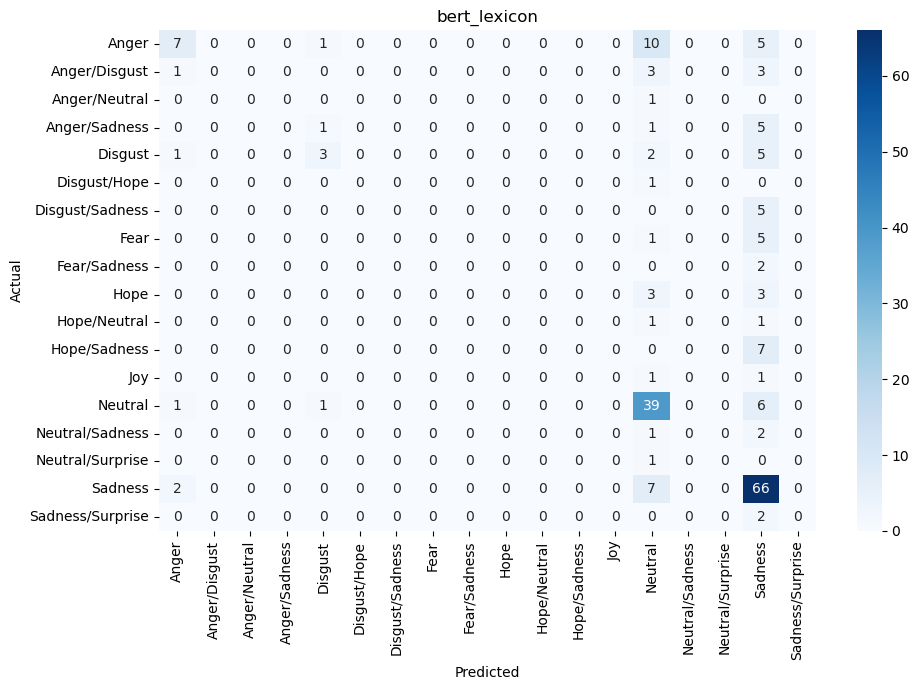

In [40]:
plot_confusion_matrix(golds=gold_emotions, predictions=predicted_emotions, path=model_config['model_id']+"_confusion_matrix.pdf", title=model_config['model_id'])

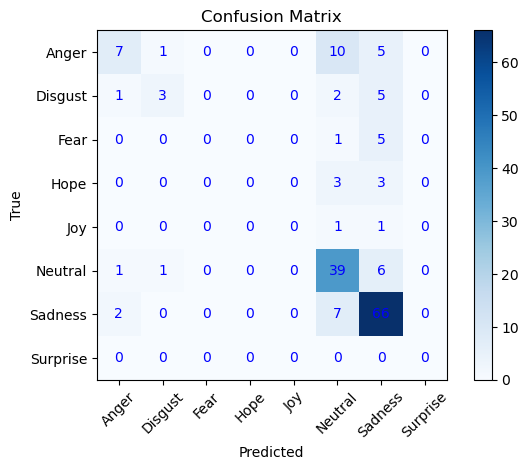

In [41]:
# Define the desired label names
label_names = ['Anger', 'Disgust', 'Fear', 'Hope', 'Joy', 'Neutral', 'Sadness', 'Surprise']

# Compute the confusion matrix
cm = confusion_matrix(gold_emotions, predicted_emotions, labels=label_names)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
ax.set_xticklabels(label_names, rotation=45)
ax.set_yticklabels(label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Add numbers in each cell
for i in range(len(label_names)):
    for j in range(len(label_names)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="b")

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
plot_model_graph(model=model, input_data=tokenizer("Hello world!", return_tensors="pt"), path=model_config['model_id']+"_graph")

In [ ]:
print_model_summary(model=model, path=model_config['model_id']+"_summary.txt")

## Save model on Google Drive

In [ ]:
trainer.state.best_model_checkpoint

In [ ]:
!mv $trainer.state.best_model_checkpoint /content/drive/MyDrive/hlt

## Inference

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/hlt/best-berta"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")

load checkpoint

In [ ]:
"""# Load the checkpoint file
checkpoint_file = "/content/roberta-base/checkpoint-1200"
#model = AutoModelForSequenceClassification.from_pretrained(checkpoint_file, num_labels=NUM_LABELS)
model = CustomSequenceClassification.from_pretrained(checkpoint_file, num_labels=NUM_LABELS, num_extra_dims = 10)
trainer = Trainer(model=model)
# Perform prediction using the loaded checkpoint
predictions = trainer.predict(dev_set)"""

In [ ]:
gold_emotions = label_encoder.decode(predictions.label_ids)
predicted_emotions = predict_emotions(predictions, gold_emotions)

In [ ]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics